# Load packages

In [2]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from itertools import combinations, chain
from upsetplot import from_memberships
import math
import matplotlib.lines as mline

# needed for editable text in svg format
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['text.usetex'] = False
plt.rcParams['svg.fonttype'] = 'none'

# import custom colormaps
from colormaps import *

# import metadata for dataset(s)
from M194_M220_metadata import *

%matplotlib inline

# Functions

## Processing

In [3]:
def clean_up_data(df_dirty, to_drop = ['OB', 'ACAi', 'ACAc', 'HIP'], inj_site="OMCi"):
    """Clean up datasets so all matrices are in the same format. Function 
        (1) drops unwanted columns, e.g. negative controls or dissections of other injection sites. 
        (2) renames RN (allen acronym) as BS (my brainstem acronym)
        (3) drops neurons w/ 0 projections after dropped columns

    Args:
        df_dirty (DataFrame): Pandas dataframe (neurons x area) that needs to be processed
        to_drop (list, optional): columns to drop. Defaults to ['OB', 'ACAi', 'ACAc', 'HIP'].
        inj_site (str, optional): Injection site. Defaults to "OMCi".

    Returns:
        DataFrame: Cleaned up data in dataframe format.
    """

    # 1. drop unused areas
    dropped = df_dirty.drop(to_drop, axis=1)

    # 2. change RN to bs
    replaced = dropped.rename(columns={'RN':'BS'})

    # 3. drop neurons w/ 0 projections after removing negative regions
    if type(inj_site)==str:
        nodes = replaced.drop([inj_site], axis=1).sum(axis=1)
    else:
        nodes = replaced.drop(inj_site, axis=1).sum(axis=1)
    
    n_idx = nodes > 0 # non-zero projecting neurons
    clean = replaced[n_idx]
    
    return clean



In [4]:
def sort_by_celltype(proj, it_areas=["OMCc", "AUD", "STR"], ct_areas=["TH"],
                      pt_areas=["AMY","HY","SNr","SCm","PG","PAG","BS"],
                      sort=True):
    """
    Function takes in projection matrix and outputs matrix sorted by the 3 major celltypes:
    - IT = intratelencephalic (projects to cortical and/or Striatum), type = 10
    - CT = corticalthalamic (projects to thalamus w/o projection to brainstem), type = 100
    - PT = pyramidal tract (projects to brainstem += other areas), type = 1000
    Returns single dataframe with cells sorted and labelled by 3 cell types (IT/CT/PT)

    Args:
        proj (DataFrame): pd.DataFrame of BC x area. Entries can be normalized BC or binary.
        it_areas (list, optional): Areas to determine IT cells. Defaults to ["OMCc", "AUD", "STR"].
        ct_areas (list, optional): Areas to determine CT cells. Defaults to ["TH"]. Don't actually use this...
        pt_areas (list, optional): Areas to determine PT cells. Defaults to ["AMY","HY","SNr","SCm","PG","PAG","BS"].
        sort (bool, optional): Whether to sort by cell type or return w/ original index. Defaults to True.
    
    Returns:
        df_out (DataFrame): Returns dataframe with extra column (type) labelled and sorted by cell type
    """
    
    ds=proj.copy()
 
    # Isolate PT cells
    pt_counts = ds[pt_areas].sum(axis=1)
    pt_idx = ds[pt_counts>0].index
    ds_pt = ds.loc[pt_idx,:]
    ds_pt['type'] = "PT"

    # Isolate remaining non-PT cells
    ds_npt = ds.drop(pt_idx)

    # Identify CT cells by thalamus projection
    th_idx = ds_npt['TH'] > 0
    ds_th = ds_npt[th_idx]
    if sort:
        ds_th = ds_th.sort_values('TH', ascending=False)
    ds_th['type'] = "CT"

    # Identify IT cells by the remaining cells (non-PT, non-CT)
    ds_nth = ds_npt[~th_idx]
    if sort:
        ds_nth = ds_nth.sort_values(it_areas,ascending=False)
    ds_nth['type'] = "IT"

    # combine IT and CT cells
    ds_npt = pd.concat([ds_nth, ds_th])

    # combine IT/CT and PT cells
    if sort:
        sorted = pd.concat([ds_npt,ds_pt],ignore_index=True)
        df_out=sorted.reset_index(drop=True)
    else:
        df_out = pd.concat([ds_npt,ds_pt]).sort_index()

    return(df_out)



In [5]:
def dfs_to_node_proportions(df_list, 
                            drop=["OMCi", "type"], 
                            keep=None, cell_type=None, 
                            meta=metadata, inj_site="OMCi",
                            return_nodes=False):
    """Output dataframe of proportions of each node degree in format that can be plotted with seaborn

    Args:
        df_list (list): 
            - List of dataframes of neurons/BC by areas
        drop (list, optional): 
            - Defaults to ["OMCi", "type"]
            - list of areas/columns to drop before calculating proportions
        keep (list, optionl):
            - if present, only keep selected columns
            - Defaults to None.
        cell_type (string, optional): 
            - Specify cell types in df, either IT, CT or PT
            - Defaults to None

    Returns:
        plot_df (pandas_dataframe):
            - returns dataframe in format for seaborn plotting
            - columns = node_degree, node degree proportion, total cell count, percentage, and other metadata
    """

    plot_df = pd.DataFrame(columns=["node_degree", "proportion", "count", "percentage", "mice", "species", "dataset"])

    if cell_type == "IT":
        drop.extend(['TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG',
       'PAG', 'BS'])
        print(drop)
    elif cell_type == "PT":
        drop.extend([inj_site[:-1]+"c", 'AUD', "AMY"])
    
    if keep:
        drop = [] # if only selecting few columns, don't need drop

    mice = meta["mice"]
    species = meta["species"]
    dataset = meta["dataset"]

    node_list = []

    for i in range(len(df_list)):
        df = df_list[i].drop(drop, axis=1)
        if keep:
            df = df.loc[:, keep]
        nodes = df.sum(axis=1)
        node_list.append(nodes)
        node_counts = nodes.value_counts().sort_index()
        node_proportion = node_counts/node_counts.sum()
        node_percentage = node_proportion*100

        # calculate cdf
        cdf_prop = []
        cdf = 0
        for n in node_counts.index.values:
            cdf += node_proportion[n]
            cdf_prop.append(cdf)


        # total = node_counts.sum()
        df_add = pd.DataFrame({"node_degree":node_counts.index.values, "proportion":node_proportion.values, 
        "count":node_counts, "percentage":node_percentage.values, "mice":mice[i], "species":species[i], 
        "dataset":dataset[i], "cdf_prop":cdf_prop})
        plot_df = pd.concat([plot_df, df_add])
    
    if return_nodes:
        return plot_df, node_list
    else:
        return plot_df

In [6]:
def proportion_ttest(df, sp1="MMus", sp2="STeg", to_plot='proportion', 
                     groupby="area", test="ttest"):
    """output dataframe based on comparison of species individuals
        output dataframe can be used for making volcano plot

    Args:
        df (DataFrame): DataFrame of repeated values across species and inviduals.
        sp1 (str, optional): Group1 to use as comparison. Defaults to "MMus".
        sp2 (str, optional): Group1 to use as comparison. Defaults to "STeg".
        to_plot (str, optional): Column to calculate comparison. Defaults to 'proportion'.
        groupby (str, optional): Categories within to do comparison. Defaults to "area".
        test (str, optional): What test to use ["ttest", "mannwhitneyu"]. Defaults to "ttest".
    Returns:
        plot (DataFrame): pd.DataFrame w/ pvalues, means across species, and log. Can be used for volcano plot.
    """

    groups = sorted(df[groupby].unique())

    # sp1
    sp1_df = df[df["species"]==sp1]
    sp1_array = sp1_df.pivot_table(columns='mice', values=to_plot, index=groupby).values

    sp2_df = df[df["species"]==sp2]
    sp2_array = sp2_df.pivot_table(columns='mice', values=to_plot, index=groupby).values

    if test=="ttest":
        results = stats.ttest_ind(sp1_array, sp2_array, axis=1)
    elif test=="mannwhitneyu":
        results = stats.mannwhitneyu(sp1_array, sp2_array, axis=1)
    
    p_vals = results[1]
    plot = pd.DataFrame({groupby:groups, "p-value":p_vals})
    plot[sp1+"_mean"] = sp1_array.mean(axis=1)
    plot[sp1+"_sem"] = stats.sem(sp1_array, axis=1)
    plot[sp2+"_mean"] = sp2_array.mean(axis=1)
    plot[sp2+"_sem"] = stats.sem(sp2_array, axis=1)
    # plot["effect_size"] = (plot["st_mean"]-plot["mm_mean"]) / (plot["st_mean"] + plot["mm_mean"]) # modulation index
    plot["fold_change"] = plot[sp2+"_mean"]/(plot[sp1+"_mean"])
    plot["log2_fc"] = np.log2(plot["fold_change"])
    plot["nlog10_p"] = -np.log10(plot["p-value"])
    plot["p<0.05"] = plot["p-value"]<0.05

    return(plot)

In [7]:
def estimate_n_total(df, plot_areas):
    """Calculate estimated N_total based on observed number of neuron per areas.
       Works with IT and PT areas with as many areas as wanted. See Han et al., 2017
       for more detail/formula.

    Args:
        df (DataFrame): Binary matrix of BC x areas
        areas (list): List of areas using to calculat motifs. Should be list of strings.
    Returns:
        n_total (int): Estimated n total for input data.
    """
    n_obs = df.shape[0]
    n_areas = df.sum()
    all_terms = []
    for k in range(1, len(plot_areas)+1):
        combos = list(combinations(plot_areas, k))
        term = 0
        for i in range(len(combos)):
            product = 1
            for j in range(len(combos[i])):
                n_area = n_areas[combos[i][j]]
                product = product*n_area
            term = term + product
        all_terms.append(term)

    # need to subtract first term from n_obs
    all_terms[0] = n_obs - all_terms[0]

    # multiply every other by -1 starting w/ 3rd term
    for l in range(len(all_terms)):
        if l>=2 and l%2==0:
            all_terms[l] = -1*all_terms[l]

    # find roots of polynomial
    roots = np.roots(all_terms)

    # convert to real numbers if numbers complex
    if isinstance(roots[0],complex):
        reals = []
        for num in roots:
            if num.imag==0:
                reals.append(num.real)
    else:
        reals = roots.copy()

    # pick root that is more than n_obs
    # if can't find root more than n_obs, return n_obs as n_total
    n_total = n_obs
    for num in reals:
        if num > n_obs:
            n_total = round(num)

    return(n_total)

In [8]:
def df_to_motif_proportion(df, areas, proportion=True, subset=None):
    """Make series to feed into upset plot based on given data and area list

    Args:
        df (pd.DataFrame): df containing bc x area
        areas (list): List of areas (str) to be plotted
        proportion (bool, optional): Whether to output counts or proportions. Defaults to True.
        subset (str, optional): Whether to subset on certain brain area (e.g. 'PAG'). Defaults to None.
    Returns:
        plot_s (DataFrame): dataframe of proprotion/count of each motif for input data.
    """

    # generate all combinations of areas in true/false list
    area_comb = []
    for i in range(len(areas)):
        n = i+1
        area_comb.append(list(combinations(areas, n)))

    area_comb_list = list(chain.from_iterable(area_comb)) # flatten list
    memberships = from_memberships(area_comb_list) # generate true/false
    area_comb_TF = memberships.index.values # extract array w/ true/false values
    area_comb_names = memberships.index.names # get order of areas

    # calculate number of neurons of each motif
    comb_count = []
    for tf in area_comb_TF:
        neurons = df
        for i in range(len(area_comb_names)):
            # subset dataset on presence/absence of proj
            neurons = neurons[neurons[area_comb_names[i]]==tf[i]]
        if proportion: # return proportion
            comb_count.append(neurons.shape[0]/df.shape[0])
        else: # return count
            comb_count.append(neurons.shape[0])

    plot_s = from_memberships(area_comb_list, data=comb_count)

    if subset:
        motif_areas = plot_s.index.names
        subset_idx = motif_areas.index(subset)
        idx = [i for i, x in enumerate(plot_s.index) if x[subset_idx]]
        plot_s = plot_s[idx]

    return(plot_s)

In [9]:
def df_to_motif_estimated_proportions(data, combinations, adjust_total=False):
    """Given dataframe of cells and index of combinations (generated from df_to_motif_prportions),
    return series similar to output for df_to_motif_proportions. Proportions are estimated
    by multiplying the bulk/population proporitons/probabilities.

    Args:
        data (DataFrame): DataFrame of BC x areas, binary
        combinations (MultiIndex): Index from output of df-to_motif_proportions
        adjust_total (bool): whether to adjust the matrix w/ unobserved neurons. Defaults to False.
    Returns:

    """

    # adjust n_total (add in 0 projectors), if not done
    if adjust_total:
        # calculate n_total
        n_obs = data.shape[0]
        n_total = estimate_n_total(data, combinations.names)
        n_unobs = np.array(n_total )- np.array(n_obs)
        unobs_df = pd.DataFrame(0, index=np.arange(n_unobs), columns=data.columns)
        df = pd.concat([data, unobs_df]).reset_index(drop=True)
    else:
        df = data.copy()

    # get brain areas specified in combinations
    names = list(combinations.names)
    
    # subset df to just columns used in motifs
    df_subset = df.loc[:,names]

    # get bulk proportions across those areas
    bulk_prop = df_subset.sum(axis=0)/df.shape[0]

    # calculate expected motif proportion based on product of bulk proportions
    expected_proportions = []
    names = combinations.names
    for i in range(combinations.shape[0]):
        motif = combinations[i]
        product = 1

    
        for j in range(len(names)):
            if motif[j]: # if area in motif, multiply by bulk probability
                product = product * bulk_prop[names[j]]
            else: # if area not in motif, multiply by 1-bulk probability (chance of not projecting to area)
                product = product * (1-bulk_prop[names[j]])
        
        expected_proportions.append(product)

    motif_expected_prop = pd.Series(expected_proportions, index=combinations)

    return(motif_expected_prop)

In [10]:
def TF_to_motifs(index):
    """Generate motif strings from True/False MultiIndex genreated by df_to_motif_proportion()

    Args:
        index (MultiIndex): True/False for area combinations
    Returns:
        array of strings for area combinations
    """
   
    motifs_strings = []
    for r in index:
        motif = ""
        for i in range(len(index.names)):
            if r[i]:
                motif = motif+index.names[i]+"_"
        motifs_strings.append(motif)

    return(motifs_strings)

In [11]:
def dfs_to_cdf(df_list, plot_areas, resolution=1000, metadata=metadata):
    """Takes in list of DFs of count(N) data and returns dataframe w/ cdf data that can be plotted.
    Returned Dataframe includes metadata

    Args:
        df_list (list): list of DataFrames of count(N) data.
        plot_areas (list): List of strings of areas to calculate cdfs.
        resolution (int, optional): Used to determine resolution of cdf line. Defaults to 1000.
        medatadata (df, optional): Metadata where row corresponds to df_list indices. Defaults to metadata.
    Returns:
        cdf_df (DataFrame): Dataframe of cdf summary values
        all_ecdfs (list): Empirical cdf 
    """

    # combine all DFs into one df labelled w/ metadata
    all_bc = pd.DataFrame(columns=list(df_list[0].columns)+["mice", "species", "dataset"])
    for i in range(metadata.shape[0]):
        df = df_list[i].copy(deep=True)
        df['mice'] = metadata.loc[i, 'mice']
        df['species'] = metadata.loc[i, "species"]
        df['dataset'] = metadata.loc[i, "dataset"]
        all_bc = pd.concat([all_bc, df])

    all_bc = all_bc.reset_index(drop=True)

    cdf_df = pd.DataFrame(columns=["x", "cdf", "mice", "species", "dataset", "area"])

    all_ecdfs = {}

    # calculate cdf by area, then add by mouse
    for area in plot_areas:
        # just use nonzero BC
        area_idx = all_bc[area] > 0
        area_bc = all_bc.loc[area_idx, [area, "mice", "species", "dataset"]]
        # get min/max for each area to set cdf bounds
        area_min = area_bc[area].min()
        area_max = area_bc[area].max()

        for i in range(metadata.shape[0]):
            micei = metadata.loc[i, 'mice']
            mice_bc = area_bc[area_bc['mice']==micei]
            if mice_bc[area].sum()==0:
                print("NO BARCODES, cannot compute ECDF for", area, metadata.loc[i,'mice'])
            else:
                # print(area, metadata.loc[i,"mice"])
                ecdf = ECDF(mice_bc[area])
                x = np.logspace(np.log10(area_min), np.log10(area_max), num=resolution)
                y = ecdf(x)

                int = pd.DataFrame({"x":x, "cdf":y, "mice":metadata.loc[i,"mice"], "species":metadata.loc[i,"species"], 
                                    "dataset":metadata.loc[i,"dataset"], "area":area})
                cdf_df = pd.concat([cdf_df, int])
                all_ecdfs[micei+"_"+area] = ecdf

    return(cdf_df, all_ecdfs)

## Plotting

In [12]:
def plot_species_cdf(df, x="node_degree", y="cdf_prop", hue="species",
                     title="", xlabel="Node Degree", ylabel="Cumulative Proportion",
                     figsize=None, jitter=False, concat=False, hue_order=None,
                     dot_size=6, individual=False, line_alpha=0.2, dot_alpha=0.7,
                     mean_alpha=0.7, hide_legend=False):
    """Plots individual lines for each animal

    Args:
        df (_type_): _description_
        x (str, optional): _description_. Defaults to "node_degree".
        y (str, optional): _description_. Defaults to "cdf_prop".
        hue (str, optional): _description_. Defaults to "species".
        title (str, optional): _description_. Defaults to "".
        xlabel (str, optional): _description_. Defaults to "Node Degree".
        ylabel (str, optional): _description_. Defaults to "Proportion CDF".
        figsize (_type_, optional): _description_. Defaults to None.
    """
    fig = plt.figure(figsize=figsize)


    
    if not concat:
        if individual:
            df["x_str"] = df[x].astype(str)
            sns.lineplot(df, x="x_str", y=y, hue=hue, alpha=line_alpha, 
                     hue_order=hue_order, units="mice", estimator=None, markers=True)
        sns.stripplot(df, x=x, y=y, hue=hue, jitter=jitter, alpha=dot_alpha, 
                    hue_order=hue_order, size=dot_size)
            
    sns.pointplot(df, x=x, y=y, hue=hue, marker="_", alpha=mean_alpha,
              zorder=10, hue_order=hue_order)
    
    ax = plt.gca()
    ax.spines[["top","right"]].set_visible(False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(0,1.1)

    if hide_legend:
        ax.legend().set_visible(False)

    return(fig)

In [13]:
def plot_cdf(data, plot_areas, log=True, title="", color_by="species", colors=[blue_cmp.colors[255], orange_cmp.colors[255]],
             individual=True, meta=metadata, legend=True, fig_size=(3,3), calc_cdf=True):
    """Takes in countN data and returns cdf plots

    Args:
        data (list): list of DataFrames of count(N), where each element in animal
        plot_areas (list): list of strings of areas to include in final output
        log (bool, optional): Whether to use log on axis scale. Defaults to True.
        title (str, optional): figure title. Defaults to "".
        color_by (str, optional): Can be "mice", "species", or "dataset", what to label as metadata. Defaults to "species".
        colors (list, optional): colors used to label cdfs. Defaults to [blue_cmp.colors[255], orange_cmp.colors[255]].
        individual (bool, optional): _description_. Defaults to True.
        meta (_type_, optional): _description_. Defaults to metadata.
        calc_cdf (bool, optional): Whether to calcualte cdf or not. Defaults to True.
    """


    # calculate ecdf per animal and put into dataframe
    if calc_cdf:
        cdf_df, foo = dfs_to_cdf(data, plot_areas=plot_areas, metadata=meta)
    else:
        cdf_df = data.copy()

    # calculate number of axes needed
    n = math.ceil(len(plot_areas)/5) # round up divide by 4 = axs rows

    if len(plot_areas)==1:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
        ax_list = [ax]
    else:
        fig, axs = plt.subplots(n, 5, figsize=(20, 5*n))
        ax_list = axs.flat

    i = 0
    for ax in ax_list:

        if i < len(plot_areas):
            area = plot_areas[i]

            plot = cdf_df[cdf_df['area']==area]
            
            groups = plot[color_by].unique()

            plot_1 = plot[plot[color_by] ==groups[0]]
            plot_2 = plot[plot[color_by] ==groups[1]]

            if individual:
                sns.lineplot(plot_1, x="x", y="cdf", estimator=None, units="mice", color=colors[0], ax=ax) # plots individual mice
                sns.lineplot(plot_2, x="x", y="cdf", estimator=None, units="mice", color=colors[1], ax=ax) # plots individual mice
            else: 
                sns.lineplot(plot_1, x="x", y="cdf", ax=ax) # plots mean ci95
                sns.lineplot(plot_2, x="x", y="cdf", ax=ax) # plots mean ci95
            
            # get rid of top and right axis
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            if log:
                ax.set_xscale("log")
            ax.set_xlabel("Normalized Counts")

            ax.set_title(area)
            i+=1
        else:
            ax.axis('off')

    # create cutom legend
    if legend:
        colors = [colors[0], colors[1]]
        lines = [mline.Line2D([0], [0], color=c, linewidth=3) for c in colors]
        labels = [groups[0], groups[1]]
        fig.legend(lines,labels, bbox_to_anchor=(0.75, 0.935))

    # increase text size
    plt.rcParams.update({'font.size': 12})

    if title!="":
        plt.suptitle(title, y=0.93, size=20)
    elif title=="":
        plt.suptitle("By "+color_by, y=0.93, size=20)

    # erase minor ticks
    plt.minorticks_off()

    # set figure size
    fig = plt.gcf()
    fig.set_size_inches(fig_size[0],fig_size[1])

    return(fig)

In [14]:
def plot_fc_dotplot(data, selection=None, color="tab:orange",
                    title="IT Motif Proportions \nlog2(fold change)",
                    y="log2fc",
                    x="motifs",
                    ylabel='$log_{2}$($\dfrac{Observed}{Expected}$)',
                    xlabel="Motifs",
                    order = ["AUD_", "AUD_OMCc_", "AUD_STR_", "AUD_OMCc_STR_", "OMCc_", "STR_", "OMCc_STR_"],
                    hline=0,
                    vline=None,
                    figsize=(8,4),
                    ylim=None,
                    xlim=None,
                    rotate_xlabels=True
):
    """Dot plot where x = motif, y = log2fc(obs/exp)

    Args:
        data (DataFrame): Includes metadata, each row motif, column of log2fc
        color (str, optional): Color used for dots/markers. Defaults to "tab:orange".
        selection (tuple/list, optional): First element is column to sort on, second element is selection bias. Defaults to None.
        title (str, optional): Title. Defaults to "IT Motif Proportions \nlog2(fold change)".
        y (str, optional): Variable to plot on y axis. Defaults to "log2fc".
        order (list, optional): Order in which to plot motifs. Defaults to ["AUD_", "AUD_OMCc_", "AUD_STR_", "AUD_OMCc_STR_", "OMCc_", "STR_", "OMCc_STR_"].
    """

    # select data based on selection factor(s)
    if selection:
        data = data[data[selection[0]]==selection[1]]
    
    fig = plt.figure(figsize=figsize)

    sns.stripplot(x=x, y=y, color=color,
                data=data, jitter=0, size=6, order=order, alpha=0.3)
    sns.pointplot(data, x=x, y=y, order=order, color=color,
                ls="", zorder=10, marker="+", errorbar="se")
    
    if hline is not None:
        plt.axhline(hline, color="grey", ls="--", alpha=0.6)
    if vline is not None:
        plt.axvline(vline, color="grey", ls="--", alpha=0.6)

    # rotate xaxis labels
    if rotate_xlabels:
        plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

    # set limits to equal
    plt.ylim(ylim)
    plt.xlim(xlim)

    ax = plt.gca()
    # get rid of top/side axis
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    plt.title(title)
    
    return(fig)

<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_29016/1937076660.py:5: SyntaxWarning: invalid escape sequence '\d'
  ylabel='$log_{2}$($\dfrac{Observed}{Expected}$)',


In [15]:
def plot_nodes_stacks(proportions, title=""):
    """Takes output of dfs_to_node_propotions() and turns it into a stacked barchart by species.

    Args:
        proportions (_type_): _description_
        title (str, optional): _description_. Defaults to "".
    """

    plot_df = pd.pivot(proportions, index="species", columns="node_degree", values="proportion")
    plot_df.plot(kind='bar', stacked=True)
    plt.legend(bbox_to_anchor=(1.05,1))
    plt.rcParams.update({'font.size': 12})
    fig = plt.gcf()
    fig.set_size_inches((2,4))
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.ylabel("node proportion")
    plt.title(title, size=20, pad=20)

    return(fig)

# Load data


In [16]:
# Paths and load data
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
# out_path = '/Volumes/Data/Emily/figures/fig_3_sc/python_out/'
# out_path = '/Volumes/Data/Emily/figures/fig_2_mapseq/figure_pics/'
out_path = "/Users/eisko/Documents/CSHL/mapseq_paper/svg_images/"

#### load data - OMC
omc_bin = pd.read_pickle(in_path+"M194_M220_OMC_bin.pkl")



# Preprocessing of data


In [17]:
# bin processing
omc_clean = [clean_up_data(df) for df in omc_bin]
omc_type = [sort_by_celltype(df) for df in omc_clean]

# seperate it cells
omc_it = [df[df['type']=="IT"] for df in omc_type]

# seperate aud cells
omc_aud = [df[df["AUD"]>0] for df in omc_it]

# get not aud cells
omc_naud = [df[df["AUD"]==0] for df in omc_it]

# seperate pt cells
omc_pt = [df[df['type']=="PT"] for df in omc_type]

# seperate pag cells
omc_pag = [df[df["PAG"]>0] for df in omc_pt]

# seperate non-pag cells
omc_npag = [df[df["PAG"]==0] for df in omc_pt]


# Plot by node degree

In [18]:
# calculate node proportions
it_nodes_prop = dfs_to_node_proportions(omc_it, cell_type="IT", 
                                   drop=["OMCi", "type"])
aud_nodes_prop = dfs_to_node_proportions(omc_aud, cell_type="IT", 
                                   drop=["OMCi", "type"])
naud_nodes_prop = dfs_to_node_proportions(omc_naud, cell_type="IT", 
                                   drop=["OMCi", "type"])


['OMCi', 'type', 'TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG', 'PAG', 'BS']
['OMCi', 'type', 'TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG', 'PAG', 'BS']


/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_29016/3798728876.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_29016/3798728876.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])


['OMCi', 'type', 'TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG', 'PAG', 'BS']


/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_29016/3798728876.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])


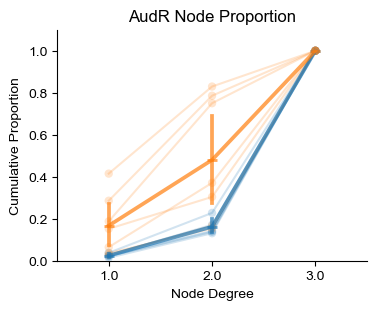

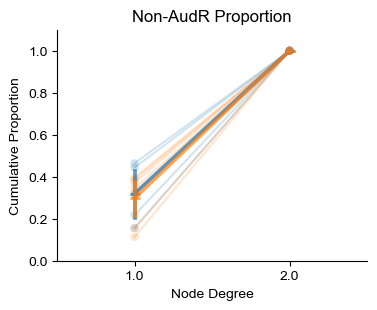

In [19]:
# Plot cdfs

plot_species_cdf(aud_nodes_prop, title="AudR Node Proportion", figsize=(4,3),
                 individual=True, hide_legend=True, jitter=False, dot_alpha=0.2)
plt.savefig(out_path+"node_cdf_aud.svg", dpi=300, bbox_inches="tight")
plt.show()

plot_species_cdf(naud_nodes_prop, title="Non-AudR Proportion", figsize=(4,3),
                 individual=True, hide_legend=True, jitter=False, dot_alpha=0.2)
plt.savefig(out_path+"node_cdf_naud.svg", dpi=300, bbox_inches="tight")
plt.show()

In [20]:
# significance testing
print("IT:")
test = proportion_ttest(it_nodes_prop, to_plot="proportion",
                 groupby="node_degree", test="mannwhitneyu")
display(test)

print("AUD:")
test = proportion_ttest(aud_nodes_prop, to_plot="proportion",
                 groupby="node_degree", test="mannwhitneyu")
display(test)

print("non-aud:")
test = proportion_ttest(naud_nodes_prop, to_plot="proportion",
                 groupby="node_degree", test="mannwhitneyu")
display(test)

IT:


,node_degree,p-value,MMus_mean,MMus_sem,STeg_mean,STeg_sem,fold_change,log2_fc,nlog10_p,p<0.05
0,1.0,0.638889,0.306021,0.060266,0.281662,0.044279,0.920401,-0.119665,0.194575,False
1,2.0,1.000000,0.651863,0.056929,0.646041,0.031594,0.991067,-0.012945,-0.000000,False
2,3.0,0.267677,0.042115,0.020240,0.072297,0.019879,1.716645,0.779592,0.572389,False


AUD:


,node_degree,p-value,MMus_mean,MMus_sem,STeg_mean,STeg_sem,fold_change,log2_fc,nlog10_p,p<0.05
0,1.0,0.010101,0.024119,0.003849,0.166888,0.054154,6.919399,2.790647,1.995635,True
1,2.0,0.106061,0.137718,0.014164,0.313090,0.069395,2.273412,1.184859,0.974446,False
2,3.0,0.030303,0.838163,0.017818,0.520022,0.113020,0.620431,-0.688658,1.518514,True


non-aud:


,node_degree,p-value,MMus_mean,MMus_sem,STeg_mean,STeg_sem,fold_change,log2_fc,nlog10_p,p<0.05
0,1.0,0.755051,0.319685,0.060709,0.298201,0.043553,0.932796,-0.100366,0.122024,False
1,2.0,0.755051,0.680315,0.060709,0.701799,0.043553,1.031579,0.044855,0.122024,False


# Compare observed and expected motif proportions across species

In [21]:
# calculate estimates for motifs

plot_areas = ["OMCc", "AUD", "STR"]

# Estimate n-totals
n_totals = [estimate_n_total(omc_it[i], plot_areas) for i in range(len(omc_it))]

# Count obs motifs
n_obs_motifs = [df_to_motif_proportion(df, areas=plot_areas, proportion=False) for df in omc_it]
motifs = n_obs_motifs[0].index

# convert to proportions using adjusted n_totals
p_obs_motifs = [n_obs_motifs[i]/n_totals[i] for i in range(len(n_totals))]

# calculate expected proportions based on independent bulk probabilities adjusted for n_total
p_expected_motifs = [df_to_motif_estimated_proportions(df, motifs, adjust_total=True) for df in omc_it]

motif_strings = TF_to_motifs(motifs)

# put into dataframe - note p_obs is adjusted for n_total
it_motifs_df = []
for i in range(len(n_totals)):
    df = pd.DataFrame({"motifs":motif_strings, "n_shape":omc_it[i].shape[0], "n_total":n_totals[i],
                  "n_obs":n_obs_motifs[i], "p_obs":p_obs_motifs[i], "p_exp":p_expected_motifs[i],
                  "mice":metadata.loc[i,"mice"], "species":metadata.loc[i,"species"]})
    it_motifs_df.append(df)
it_motifs_df = pd.concat(it_motifs_df).reset_index(drop=True)

it_motifs_df

,motifs,n_shape,n_total,n_obs,p_obs,p_exp,mice,species
0,OMCc_,8287,8949,1123,0.125489,0.124100,MMM1,MMus
1,AUD_,8287,8949,3,0.000335,0.000980,MMM1,MMus
2,STR_,8287,8949,2668,0.298134,0.294598,MMM1,MMus
3,AUD_OMCc_,8287,8949,8,0.000894,0.001644,MMM1,MMus
4,OMCc_STR_,8287,8949,4379,0.489328,0.494259,MMM1,MMus
...,...,...,...,...,...,...,...,...
79,STR_,527,530,29,0.054717,0.053811,STM7,STeg
80,AUD_OMCc_,527,530,9,0.016981,0.018997,STM7,STeg
81,OMCc_STR_,527,530,351,0.662264,0.659190,STM7,STeg
82,AUD_STR_,527,530,4,0.007547,0.014256,STM7,STeg


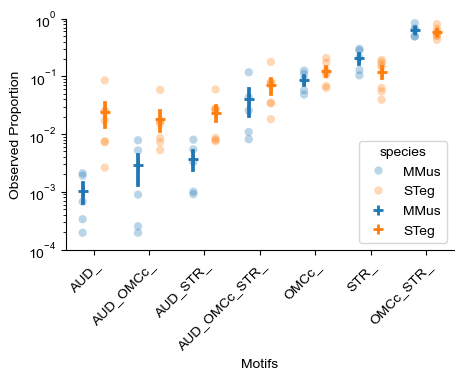

In [22]:
# plotting observed motif proportions across species

stmm_figsize=(5,3)

plt.figure(figsize=stmm_figsize)

# set order of x axis
order = ["AUD_", "AUD_OMCc_", "AUD_STR_", "AUD_OMCc_STR_", "OMCc_", "STR_", "OMCc_STR_"]

sns.stripplot(x='motifs', y='p_obs', hue='species',
                   dodge=True, data=it_motifs_df, jitter=0, size=6, order=order, alpha=0.3)
sns.pointplot(it_motifs_df, x="motifs", y="p_obs", hue="species",
              dodge=0.4, marker="+", order=order, ls="", zorder=10, errorbar="se")


# rotate xaxis labels
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.yscale("log")
plt.ylim(0.0001, 1)

plt.xlabel("Motifs")
plt.ylabel('Observed Proportion')

# get rid of top/side axis
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig(out_path+"mmus_steg_it_p_obs_plot_5x3.svg", dpi=300, bbox_inches="tight")


plt.show()

In [23]:
# calculate significance b/w species
sig_test = proportion_ttest(it_motifs_df, test="mannwhitneyu", groupby="motifs",
                            to_plot="p_obs")

sig_test

,motifs,p-value,MMus_mean,MMus_sem,STeg_mean,STeg_sem,fold_change,log2_fc,nlog10_p,p<0.05
0,AUD_,0.002525,0.001041,0.000400,0.024160,0.010665,23.214908,4.536980,2.597695,True
1,AUD_OMCc_,0.010101,0.002869,0.001544,0.018326,0.006891,6.386662,2.675062,1.995635,True
2,AUD_OMCc_STR_,0.267677,0.041023,0.020097,0.070286,0.020060,1.713316,0.776792,0.572389,False
3,AUD_STR_,0.010101,0.003724,0.001353,0.023474,0.006971,6.303538,2.656162,1.995635,True
4,OMCc_,0.202020,0.086338,0.014876,0.122906,0.019840,1.423539,0.509482,0.694605,False
5,OMCc_STR_,0.755051,0.625158,0.063530,0.577482,0.046235,0.923738,-0.114445,0.122024,False
6,STR_,0.148990,0.204746,0.039174,0.118758,0.024332,0.580027,-0.785808,0.826843,False


## Observed vs Expected

In [24]:
# calculate fold change
it_motifs_df["fc"] = it_motifs_df["p_obs"]/it_motifs_df["p_exp"]
it_motifs_df["log2fc"] = np.log2(it_motifs_df["fc"])

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_29016/3950584630.py:9: SyntaxWarning: invalid escape sequence '\d'
  vline=0, hline=None, xlabel='$log_{2}$($\dfrac{Observed}{Expected}$)',
/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_29016/3950584630.py:18: SyntaxWarning: invalid escape sequence '\d'
  vline=0, hline=None, xlabel="$log_{2}$($\dfrac{Observed}{Expected}$)",


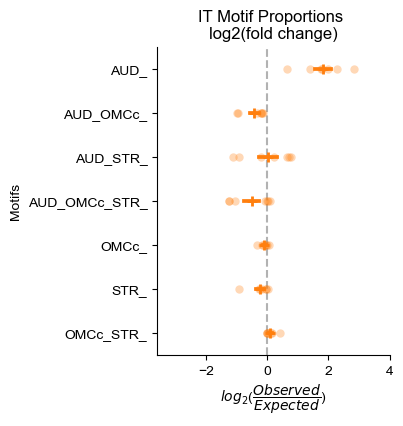

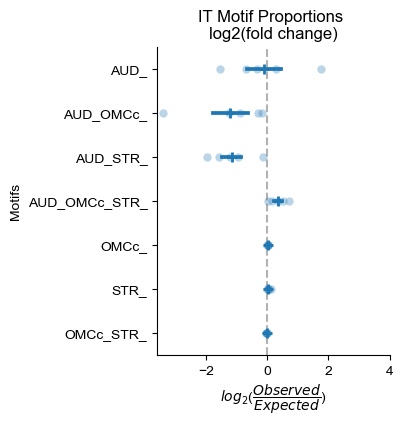

In [25]:
# Plotting motif observed vs. expected

# Steg
figsize=(3,4)

plot_fc_dotplot(it_motifs_df, x="log2fc", y="motifs",
                selection=["species", "STeg"], color="tab:orange",
                xlim=(-3.6,4), figsize=figsize, rotate_xlabels=False,
                vline=0, hline=None, xlabel='$log_{2}$($\dfrac{Observed}{Expected}$)',
                ylabel="Motifs")
# plt.savefig(out_path+"st_it_obs_exp_fc_3x4.svg", dpi=300, bbox_inches="tight")
plt.show()

# plt.figure(figsize=figsize)
plot_fc_dotplot(it_motifs_df, x="log2fc", y="motifs",
                selection=["species", "MMus"], color="tab:blue",
                xlim=(-3.6,4), figsize=figsize, rotate_xlabels=False,
                vline=0, hline=None, xlabel="$log_{2}$($\dfrac{Observed}{Expected}$)",
                ylabel="Motifs")
# plt.savefig(out_path+"mm_it_obs_exp_fc_3x4.svg", dpi=300, bbox_inches="tight")
plt.show()